# Ravar, Kerman Province, Iran
https://www.google.com/maps/place/31°11'22.0%22N+57°01'00.0%22E/@31.5704132,56.0492237,797406m/data=!3m1!1e3!4m5!3m4!1s0x0:0x0!8m2!3d31.1894444!4d57.0166667?hl=en-AU

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from osgeo import gdal, ogr
import urllib
import shutil
import glob
import zipfile
import ee
from scipy.stats import linregress

In [2]:
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [3]:
# define Pandas display settings
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Define helper functions

In [4]:
def gee_image2rect(GEEimage, reorder=False):
    coords = GEEimage.getInfo()['properties']['system:footprint']['coordinates'][0]
    lats = np.asarray(coords)[:,1]
    lons = np.asarray(coords)[:,0]
    if not reorder:
        return [lons.min(), lats.min(), lons.max(), lats.max()]
    else:
        return [lons.min(), lons.max(), lats.min(), lats.max()]
    
#print (gee_image2rect(GEEimage, False))
#print (gee_image2rect(GEEimage, True))

# create worldfile to define image coordinates
def worldfile_tofile(fname, GEEimage, dimensions):
    area = gee_image2rect(GEEimage)
    name, ext = os.path.splitext(fname)
    # use QGIS worldfile names convention 
    jext = ext[1] + ext[-1] + 'w'
    fname = os.path.join(str(os.extsep).join([name,jext]))
    with open(fname, 'w') as outfile:
        xres = (area[2]-area[0])/dimensions[0]
        yres = (area[1]-area[3])/dimensions[1]
        coefficients = [xres, 0, 0, yres, area[0], area[3]]
        print('\n'.join(map(str, coefficients)), file=outfile)

# download GEE URL and save to file
def geeurl_tofile(GEEurl, fname):
    with urllib.request.urlopen(GEEurl) as response, open(fname, 'wb') as outfile:
        shutil.copyfileobj(response, outfile)

def gee_preview_tofile(GEEimage, vis, dimensions, fname=None):
    GEEurl = GEEimage\
        .visualize(**vis)\
        .getThumbURL({'dimensions':dimensions, 'format': 'jpg'})
    #print (GEEurl)
    if fname is not None:
        geeurl_tofile(GEEurl, fname)
        worldfile_tofile(fname, GEEimage, dimensions)
    return {'url': GEEurl, 'width': dimensions[0], 'height': dimensions[1]}

def split_rect(GEEimage, n):
    rect = gee_image2rect(GEEimage)
    lats = np.linspace(rect[1], rect[3], n+1)
    lons = np.linspace(rect[0], rect[2], n+1)
    #print (lats, lons)
    cells = []
    for lt1, lt2 in zip(lats.ravel()[:-1], lats.ravel()[1:]):
        for ll1, ll2 in zip(lons.ravel()[:-1], lons.ravel()[1:]):
            cell = [lt1, ll1, lt2, ll2]
            cells.append(cell)
    return cells

def zipsbands2image(files):
    dss = []
    # merge separate file areas
    for fname in sorted(files):
        #print ('fname', fname)
        zip = zipfile.ZipFile(fname)
        # merge separate file to dataset
        ds = xr.Dataset()
        for bandname in zip.namelist():
            varname = bandname.split('.')[1]
            da = xr.open_rasterio(f'/vsizip/{fname}/{bandname}').squeeze(drop=True)
            ds[varname] = da
            da.close()
        dss.append(ds)
    return xr.merge(dss)

In [5]:
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import linregress

# band filter
def raster_filter_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1) - gaussian_filter(raster.values,g2)
    return raster

In [6]:
def plot_fractality(ax, data):
    ax.loglog(data.r, data, base=2, label='Calculated')
    ax.set_xlabel('Wavelength, m', fontsize=18)

    ax.axes.get_yaxis().set_visible(False)

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

    res = linregress(np.log2(data.r), np.log2(data))
    ax.plot(data.r, 2**(res.intercept + res.slope*np.log2(data.r)), 'r', label=f'Fitted R²={res.rvalue**2:.2f}', ls='--')

    ax.legend(fontsize=18)

    fractality = 1000*np.round((3 - (res.slope/2)),1)
    return fractality

def plot_preview(ax, GEEimage, filename):
    image = plt.imread(filename)
    ax.imshow(image, interpolation='bilinear', extent=gee_image2rect(GEEimage, True))

## Define GEE functions

In [7]:
# Function to mask clouds using the Sentinel-2 QA band.
def GEEmaskS2clouds(image):
    # Get the pixel QA band.
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    cloudMask = qa.bitwiseAnd(cloudBitMask).eq(0)
    cirrusMask = qa.bitwiseAnd(cirrusBitMask).eq(0)

    # Return the masked and scaled data, without the QA bands.
    return image\
        .updateMask(cloudMask)\
        .updateMask(cirrusMask)\
        .divide(10000)\
        .select("B.*")\
        .copyProperties(image, ["system:time_start"])

## Connect to GEE

In [8]:
service_account = 'console@gee-export-308512.iam.gserviceaccount.com'
service_key = '/Users/mbg/gee-export.json'

In [9]:
credentials = ee.ServiceAccountCredentials(service_account, service_key)
ee.Initialize(credentials)

## Define work area and scale

In [10]:
# define center of work area, decimal degrees
point = [57.016667, 31.189444]
# radius, [m]
radius = 20*1000
# scale, [m]
scale = 50

# radius, [m]
radius = 40*1000
# scale, [m]
scale = 250

# define spatial components 1*scale .. 50*scale [m]
gammas = np.arange(1,51)

GEEpoint = ee.Geometry.Point(point)
#GEEpoint.getInfo()

GEEarea = GEEpoint.buffer(radius).bounds()
GEEarea.getInfo()

{'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[56.599522505423934, 30.82962716749251],
   [57.43549720703112, 30.82962716749251],
   [57.43549720703112, 31.549398638059294],
   [56.599522505423934, 31.549398638059294],
   [56.599522505423934, 30.82962716749251]]]}

## Prepare image bands

In [11]:
# https://developers.google.com/earth-engine/datasets/catalog/JAXA_ALOS_AW3D30_V3_2
GEEdsm = ee.ImageCollection("JAXA/ALOS/AW3D30/V3_2").mosaic().select('DSM')

### Sentinel-2 composite image

In [12]:
# https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR
GEEs2srcol = ee.ImageCollection('COPERNICUS/S2_SR')\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
    .map(GEEmaskS2clouds)\
    .filterBounds(GEEarea)
GEEs2sr = GEEs2srcol\
    .median()\
    .rename(GEEs2srcol.first().bandNames().map(lambda name: ee.String('S2SR').cat(name)))\
    .select(['S2SRB2','S2SRB3','S2SRB4'])
print ('Collected Sentinel-2 SR images', GEEs2srcol.size().getInfo())
print ('Collected Sentinel-2 SR bands', GEEs2sr.bandNames().getInfo())

Collected Sentinel-2 SR images 800
Collected Sentinel-2 SR bands ['S2SRB2', 'S2SRB3', 'S2SRB4']


## Build image mosaic

In [13]:
GEEimage = \
    GEEs2sr\
    .addBands(GEEdsm)\
    .clip(GEEarea)
print ('collected bands', GEEimage.bandNames().getInfo())

collected bands ['S2SRB2', 'S2SRB3', 'S2SRB4', 'DSM']


### Make image preview and save on local filesystem
Note: we need to check the image preview quality before the image usage

In [14]:
# define visualization parameters
DEMvis = {'bands':['DSM'], 'min':400, 'max':3100,
          'palette': ['00A600','63C600','E6E600','E9BD3A','ECB176','EFC2B3','F2F2F2']}

In [15]:
print (gee_preview_tofile(GEEimage, DEMvis, (320, 320), 'dempreview.320x320.jpg')['url'])

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/abdfc51301744fd6a663e7ca976777e0-7fbec232876a891a7b25792e6ee623e4:getPixels


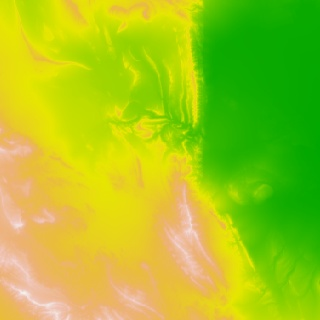

In [16]:
Image('dempreview.320x320.jpg')

In [17]:
# define visualization parameters
S2vis = {'bands':['S2SRB4', 'S2SRB3', 'S2SRB2'], 'min':0, 'max':0.3, 'gamma':1.4}

In [18]:
print (gee_preview_tofile(GEEimage, S2vis, (320, 320), 's2preview.320x320.jpg')['url'])

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/27f3809eb053d0e3ca0b69217ff121f3-3f4e09bb15ad06e75d3a2b6f8b060734:getPixels


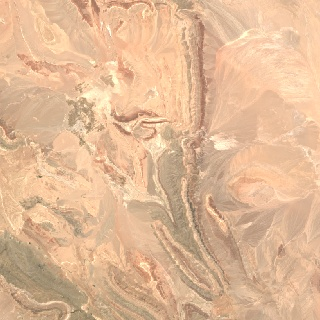

In [19]:
Image('s2preview.320x320.jpg')

### Extract raw image bands and save on local filesystem

In [20]:
GEEurl = GEEimage.getDownloadURL({'filePerBand':True, 'scale': scale, 'region': GEEarea})
print (f'downloading', GEEurl)
fname = f'image.{scale}m.zip'
geeurl_tofile(GEEurl, fname)

downloading https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/13f607e3e5cb62f6dec0a657ecb580f5-8502c4e76f0428ed3aeff594adff58c0:getPixels


### Convert downloaded zipped images chunks to compressed NetCDF file

In [21]:
%%time
ds = zipsbands2image(glob.glob(f'image.{scale}m.zip'))

CPU times: user 149 ms, sys: 29.6 ms, total: 179 ms
Wall time: 271 ms


In [22]:
# check data variables
for varname in ds.data_vars:
    print (varname, float(ds[varname].min()), float(ds[varname].max()))

S2SRB2 0.04989999905228615 0.32692500948905945
S2SRB3 0.0737999975681305 0.3880999982357025
S2SRB4 0.08446666598320007 0.4651285707950592
DSM 400.0 3095.0


In [23]:
encoding = {var: dict(zlib=True, complevel=6) for var in ds.data_vars}
ds.to_netcdf(f'image.{scale}m.nc', encoding=encoding)
print (ds.dims)

Frozen(SortedKeysDict({'y': 322, 'x': 373}))


## DEM Fractality

In [24]:
dem_power = xr.DataArray([raster_filter_range(ds.DSM, 2*(g-1), 2*(g+1)).std() for g in gammas],
                          coords=[scale*gammas],
                          dims=['r'])

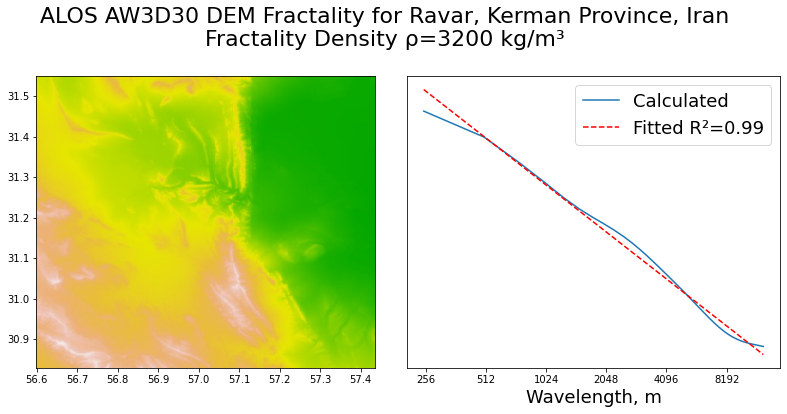

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plot_preview(ax1, GEEimage, 'dempreview.320x320.jpg')
dem_fractality = plot_fractality(ax2, dem_power)

plt.suptitle(f"ALOS AW3D30 DEM Fractality for Ravar, Kerman Province, Iran\nFractality Density ρ={dem_fractality:.0f} kg/m³", fontsize=22)
fig.tight_layout(rect=[0.03, 0.03, .97, 0.97])
plt.savefig('ALOS AW3D30 DEM Fractality for Ravar, Kerman Province, Iran.jpg', dpi=150)
plt.show()

## Satellite Image Fractality

In [26]:
img_power = xr.DataArray([raster_filter_range(ds.S2SRB4, 2*(g-1), 2*(g+1)).std() for g in gammas],
                          coords=[scale*gammas],
                          dims=['r'])

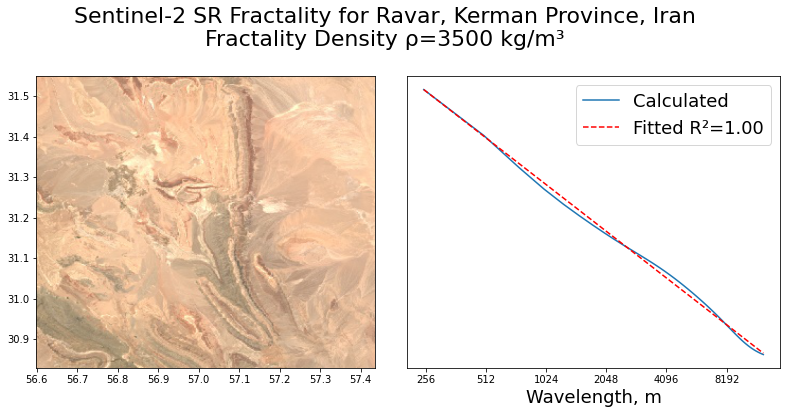

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plot_preview(ax1, GEEimage, 's2preview.320x320.jpg')
img_fractality = plot_fractality(ax2, img_power)

plt.suptitle(f"Sentinel-2 SR Fractality for Ravar, Kerman Province, Iran\nFractality Density ρ={img_fractality:.0f} kg/m³", fontsize=22)
fig.tight_layout(rect=[0.03, 0.03, .97, 0.97])
plt.savefig('Sentinel-2 SR Fractality for Ravar, Kerman Province, Iran.jpg', dpi=150)
plt.show()

## Pictures Postprocessing

In [28]:
!convert -append \
    'ALOS AW3D30 DEM Fractality for Ravar, Kerman Province, Iran.jpg' \
    'Sentinel-2 SR Fractality for Ravar, Kerman Province, Iran.jpg' \
    'Fractality for Ravar, Kerman Province, Iran.jpg'